# Bayes By Backprop - Mean Field Variational Inference

## Theoretic Foundation


 Bayesian Neural Networks (BNNs) with variational inference (VI) are an approximate Bayesian method. Here we use the mean-field assumption meaning that the variational distribution can be factorized as a product of individual Gaussian distributions. This method maximizes the evidence lower bound (ELBO) via standard stochastic gradient descent by using the reparameterization trick [Kingma, 2013](https://arxiv.org/abs/1312.6114) to backpropagate through the necessary sampling procedure. This results in a diagonal Gaussian approximation of the posterior distribution over the model parameters.\newline
 
The predictive likelihood is given by,

$$
p(Y |\theta ,X) =
\prod_{i=1}^K p(y_i|\theta,x_i) =
\prod_{i=1}^K \mathcal{N}(y_{i} | f_{\theta}(x_i), \Sigma).
$$


The prior on the weights is given by,

$$
    p(\theta) = \prod_{l=1}^L \prod_{h=1}^{V_l }\prod_{j=1}^{V_{l-1}+1} \mathcal{N}(w_{hj, l} \vert 0, \lambda)
$$
where $w_{hj, l}$ is the h-th row and the j-th column of weight matrix $\theta_L$ at layer index $L$ and $\lambda$ is the prior variance. Note that as we use partially stochastic networks, the above may contain less factors $\mathcal{N}(w_{hj, l} \vert 0, \lambda)$ depending on how many layers are stochastic. Then, the posterior distribution of the weights is obtained by Bayes' rule as

$$
    p(\theta|\mathcal{D}) = \frac{p(Y |\theta ,X) p(\theta)}{p(Y | X)}.
$$

As the posterior distribution over the weights is intractable we use a variational approximation,

$$
    q(\theta) \approx p(\theta|\mathcal{D}),
$$

that is a diagonal Gaussian. Now given an input $x^{\star}$, the predictive distribution can be obtained as

$$
    p(y^{\star}|x^{\star},\mathcal{D}) = \int p(y^{\star} |\theta , x^{\star})  p(\theta|\mathcal{D}) d\theta.
$$

As the above integral is intractable we approximate by sampling form the approximation $q(\theta)$ in \eqref{eq:postweights} to the posterior distribution in \eqref{eq:posttrue}. The weights are obtained by minimizing the evidence lower bound (ELBO) on the Kullback-Leibler (KL) divergence between the variational approximation and the posterior distribution over the weights. The ELBO is given by,

$$
    \mathcal{L}(\theta, (x^{star}, y^{star}) ) = \beta D_{KL}(q(\theta) || p(\theta) ) + \frac{1}{2}\text{ln}\left(2\pi\sigma^2\right) + \frac{1}{2\sigma^2}\left(f_{\theta}(x^{\star})-y^{\star}\right)^2 .
$$

The KL divergence can be computed analytically as both distributions are assumed to be diagonal Gaussians and the hyperparameter $\beta$ can be used to weight the influence of the variational parameters relative to that of the data. The hyperparameter $\sigma$ can be either fixed or set to be an additional output of the network. 

The predictive mean is obtained as the mean of the network output $f_{\theta}$ with $S$ weight samples from the variational approximation $\theta_s \sim q(\theta)$,

$$
     f_m(x^{\star}) = \frac{1}{S} \sum_{i=1}^S  f_{\theta_s}(x^{\star}).
$$

The predictive uncertainty is given by the standard deviation thereof,

$$
    \sigma_p(x^{\star}) = \sqrt{\frac{1}{S} \sum_{i=1}^S  \left(f_{\theta_s}(x^{\star})-  f_m(x^{\star}) \right)^2}.
$$


## Imports

In [1]:
import tempfile
import os
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import BNN_VI_ELBO_Regression, NLL
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = ToyHeteroscedasticDatamodule(batch_size=50)

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

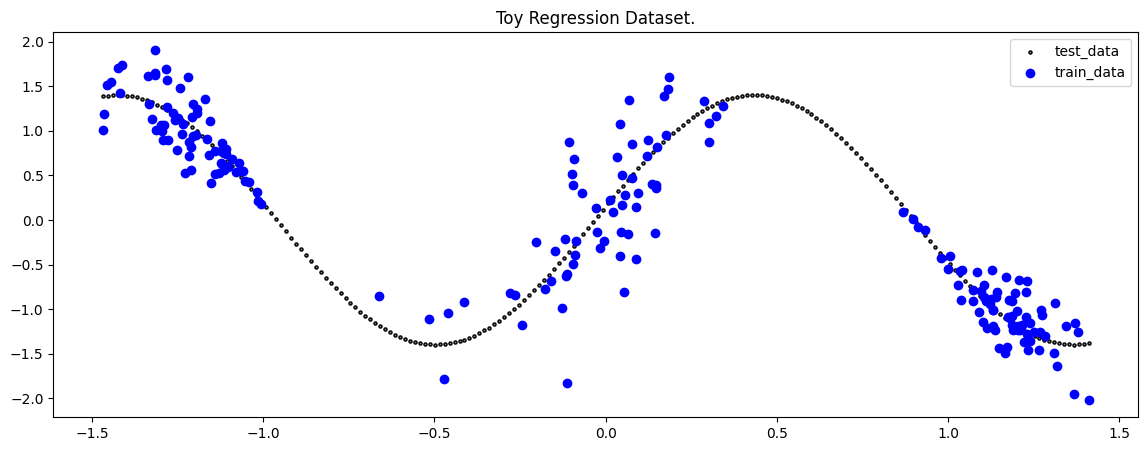

In [5]:
plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://torchgeo.readthedocs.io/en/stable/api/models.html#MLP). We are using the [Bayesian-torch](https://github.com/IntelLabs/bayesian-torch) library for which we create a LightningModule. The following MLP will be converted to a BNN inside the LightningModule.

In [6]:
network = MLP(n_inputs=1, n_hidden=[50, 50], n_outputs=2, activation_fn=nn.Tanh())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [8]:
bbp_model = BNN_VI_ELBO_Regression(
    network,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    criterion=NLL(),
    stochastic_module_names=[-1],
    num_training_points=X_train.shape[0],
    num_mc_samples_train=10,
    num_mc_samples_test=25,
    burnin_epochs=20,
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [9]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=20,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [10]:
trainer.fit(bbp_model, dm)

Missing logger folder: /tmp/tmpbp1dhc3j/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.9 K 
1 | loss_fn       | NLL              | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.011     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

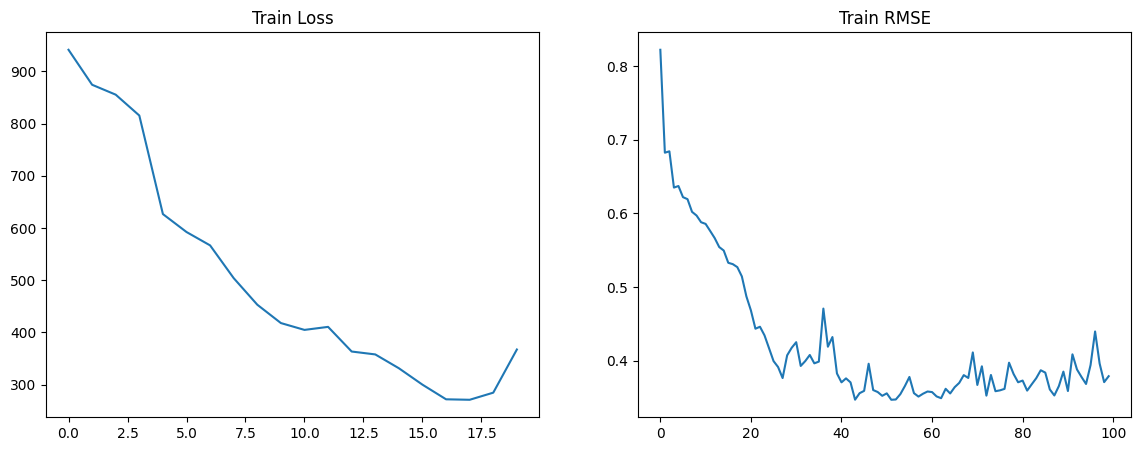

In [11]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "RMSE")

## Prediction

In [12]:
preds = bbp_model.predict_step(X_test)

## Evaluate Predictions

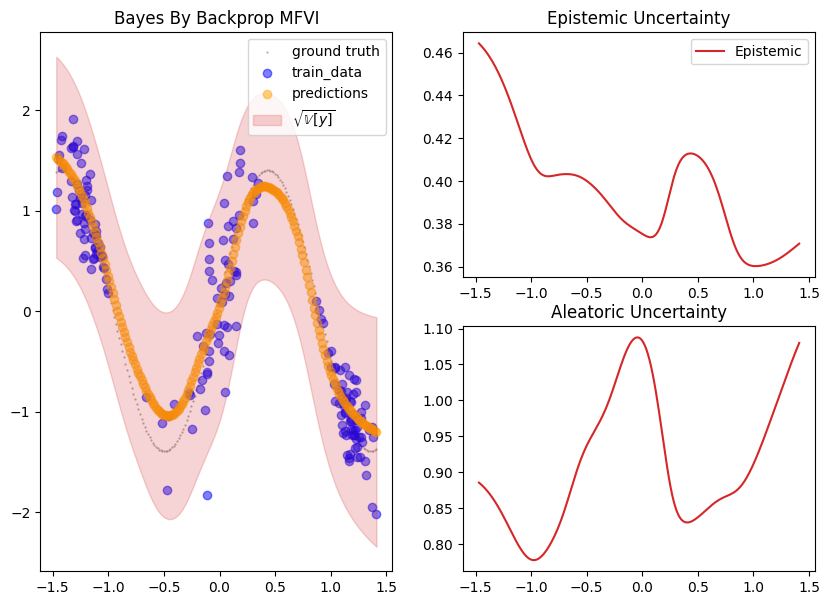

In [13]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"].squeeze(-1),
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="Bayes By Backprop MFVI",
    show_bands=False,
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

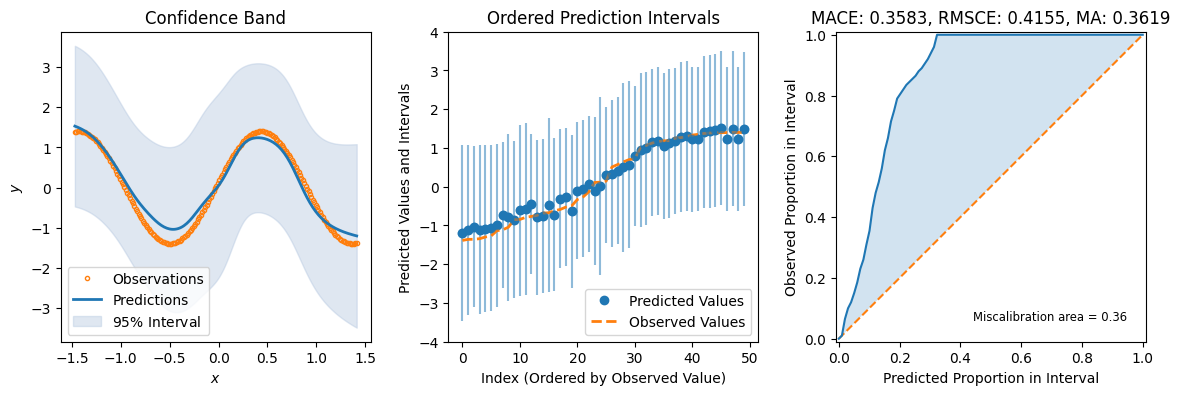

In [14]:
fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].cpu().numpy(),
    y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)